In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer

import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv("fake_reviews_dataset.csv")
df.head()
df.info()

nlp = spacy.load("en_core_web_sm")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB


In [ ]:
def preprocess_text(text):
    """
    Lowercase -> tokenize -> lemmatize -> remove stopwords & punctuation
    (NO regex used)
    """
    doc = nlp(text.lower())

    tokens = [
        token.lemma_
        for token in doc
        if not token.is_stop
        and not token.is_punct
    ]

    return " ".join(tokens)

df["clean_text"] = df["text_"].apply(preprocess_text)


In [ ]:
df.tail()

,category,rating,label,text_,clean_text
40427,Clothing_Shoes_and_Jewelry_5,4.0,OR,I had read some reviews saying that this bra r...,read review say bra run small order band cup s...
40428,Clothing_Shoes_and_Jewelry_5,5.0,CG,I wasn't sure exactly what it would be. It is ...,sure exactly little large small size think nic...
40429,Clothing_Shoes_and_Jewelry_5,2.0,OR,"You can wear the hood by itself, wear it with ...",wear hood wear hood wear jacket hood 3 in-1 ...
40430,Clothing_Shoes_and_Jewelry_5,1.0,CG,I liked nothing about this dress. The only rea...,like dress reason give 4 star order size 6.5 f...
40431,Clothing_Shoes_and_Jewelry_5,5.0,OR,I work in the wedding industry and have to wor...,work wedding industry work long day foot outsi...


In [ ]:
def calc_TF_IDF(corpus):
    vectorizer = TfidfVectorizer(
        max_features=8000,
        ngram_range=(1, 2)
    )

    X = vectorizer.fit_transform(corpus)
    return X, vectorizer

corpus = df["clean_text"].tolist()
X, vectorizer = calc_TF_IDF(corpus)

print(X.shape)

(40432, 8000)


## TASK 1 : PRODUCT CATEGORY CLASSIFICATION (MULTICLASS)

### label encoding

In [ ]:
le_cat = LabelEncoder()
y_cat = le_cat.fit_transform(df["category"])
num_classes = len(le_cat.classes_)

### train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_cat
)


### dataset

In [ ]:
class TfidfDataset(Dataset):

    def __init__(self, X, y):
        self.X = torch.tensor(X.toarray(), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_ds = TfidfDataset(X_train, y_train)
test_ds = TfidfDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)


### Neural Network

In [ ]:
class ReviewClassifier(nn.Module):

    def __init__(self, input_dim, num_classes):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)


model_cat = ReviewClassifier(X_train.shape[1], num_classes)

### training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cat.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cat.parameters(), lr=1e-3)

EPOCHS = 10

for epoch in range(EPOCHS):

    model_cat.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        out = model_cat(xb)
        loss = criterion(out, yb)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")


Epoch 1: Loss = 461.7519
Epoch 2: Loss = 226.9271
Epoch 3: Loss = 152.6337
Epoch 4: Loss = 97.8330
Epoch 5: Loss = 56.6280
Epoch 6: Loss = 32.9707
Epoch 7: Loss = 20.2584
Epoch 8: Loss = 13.1694
Epoch 9: Loss = 9.4545
Epoch 10: Loss = 6.3348


### Evaluation

In [ ]:
model_cat.eval()

all_preds = []
all_true = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model_cat(xb)

        preds = torch.argmax(out, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(yb.numpy())

print("Accuracy of Task 1:", accuracy_score(all_true, all_preds))
print(classification_report(all_true, all_preds, target_names=le_cat.classes_))


Accuracy of Task 1: 0.7587486088784469
                              precision    recall  f1-score   support

                     Books_5       0.71      0.73      0.72       874
Clothing_Shoes_and_Jewelry_5       0.79      0.82      0.81       770
               Electronics_5       0.77      0.80      0.78       798
          Home_and_Kitchen_5       0.73      0.67      0.70       811
              Kindle_Store_5       0.78      0.73      0.75       946
             Movies_and_TV_5       0.88      0.88      0.88       717
              Pet_Supplies_5       0.88      0.83      0.86       851
       Sports_and_Outdoors_5       0.62      0.60      0.61       789
Tools_and_Home_Improvement_5       0.64      0.72      0.68       772
            Toys_and_Games_5       0.80      0.83      0.81       759

                    accuracy                           0.76      8087
                   macro avg       0.76      0.76      0.76      8087
                weighted avg       0.76      0.76

## Task 2 : Fake Review Detection

In [ ]:
le_fake = LabelEncoder()
y_fake = le_fake.fit_transform(df["label"])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_fake, test_size=0.2, random_state=42, stratify=y_fake
)

In [ ]:
model_fake = ReviewClassifier(X_train.shape[1], 2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_fake.parameters(), lr=1e-3)


In [ ]:
for epoch in range(8):

    model_fake.train()
    total_loss = 0

    for xb, yb in DataLoader(TfidfDataset(X_train, y_train), batch_size=64, shuffle=True):

        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        out = model_fake(xb)
        loss = criterion(out, yb)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")


Epoch 1: Loss = 157.4141
Epoch 2: Loss = 90.5189
Epoch 3: Loss = 57.2947
Epoch 4: Loss = 27.4800
Epoch 5: Loss = 11.0351
Epoch 6: Loss = 4.6513
Epoch 7: Loss = 2.2117
Epoch 8: Loss = 1.3602


In [72]:
model_fake.eval()

preds_all = []
true_all = []

with torch.no_grad():
    for xb, yb in DataLoader(TfidfDataset(X_test, y_test), batch_size=64):
        xb = xb.to(device)
        out = model_fake(xb)

        preds = torch.argmax(out, dim=1).cpu().numpy()
        preds_all.extend(preds)
        true_all.extend(yb.numpy())

print("Accuracy of task 2:", accuracy_score(true_all, preds_all))
print(classification_report(true_all, preds_all, target_names=le_fake.classes_))


Accuracy of task 2: 0.8827748237912699
              precision    recall  f1-score   support

          CG       0.87      0.89      0.88      4044
          OR       0.89      0.87      0.88      4043

    accuracy                           0.88      8087
   macro avg       0.88      0.88      0.88      8087
weighted avg       0.88      0.88      0.88      8087



In [73]:
df["label_norm"] = df["label"].str.lower()

fake_counts = (
    df[df["label_norm"] == "cg"]
    .groupby("category")
    .size()
    .sort_values(ascending=False)
)

print(fake_counts)

category
Kindle_Store_5                  2365
Books_5                         2185
Pet_Supplies_5                  2127
Home_and_Kitchen_5              2028
Electronics_5                   1994
Sports_and_Outdoors_5           1973
Tools_and_Home_Improvement_5    1929
Clothing_Shoes_and_Jewelry_5    1924
Toys_and_Games_5                1897
Movies_and_TV_5                 1794
dtype: int64


In [74]:
total_counts = df.groupby("category").size()


In [75]:
fake_ratio = (fake_counts / total_counts * 100).round(2)

fake_stats = pd.DataFrame({
    "Total_Reviews": total_counts,
    "Fake_Reviews": fake_counts,
    "Fake_%": fake_ratio
}).fillna(0).sort_values("Fake_%", ascending=False)

fake_stats


,Total_Reviews,Fake_Reviews,Fake_%
category,,,
Books_5,4370,2185,50.0
Clothing_Shoes_and_Jewelry_5,3848,1924,50.0
Electronics_5,3988,1994,50.0
Home_and_Kitchen_5,4056,2028,50.0
Kindle_Store_5,4730,2365,50.0
Movies_and_TV_5,3588,1794,50.0
Pet_Supplies_5,4254,2127,50.0
Sports_and_Outdoors_5,3946,1973,50.0
Tools_and_Home_Improvement_5,3858,1929,50.0


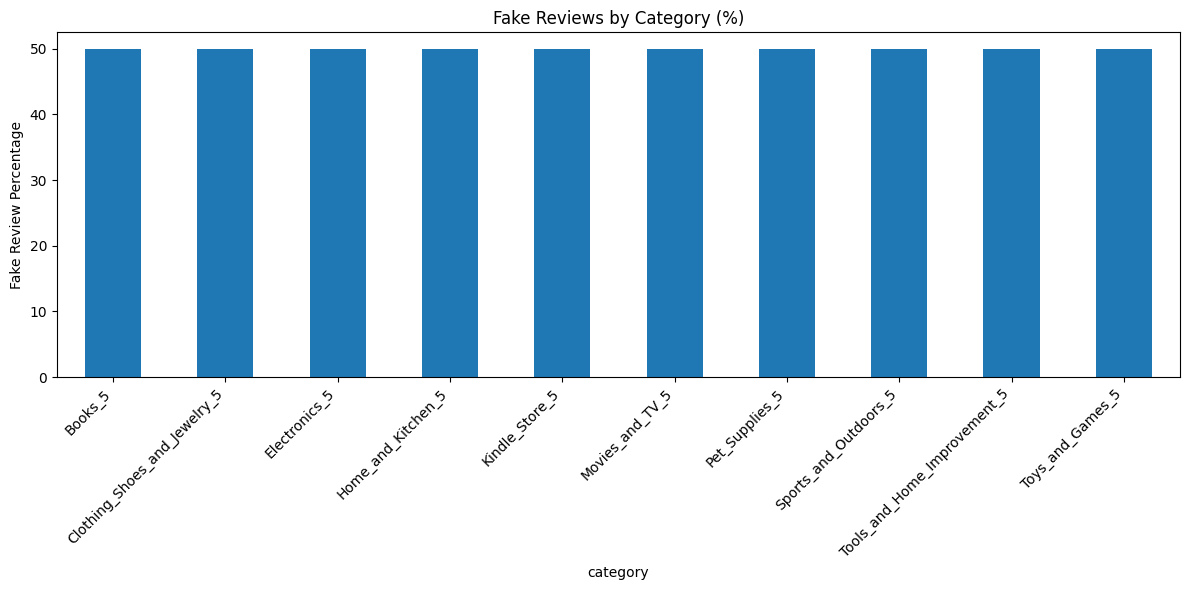

In [76]:
import matplotlib.pyplot as plt

fake_stats["Fake_%"].plot(kind="bar", figsize=(12,6))
plt.ylabel("Fake Review Percentage")
plt.title("Fake Reviews by Category (%)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## Task 3 : Word Cloud Generation

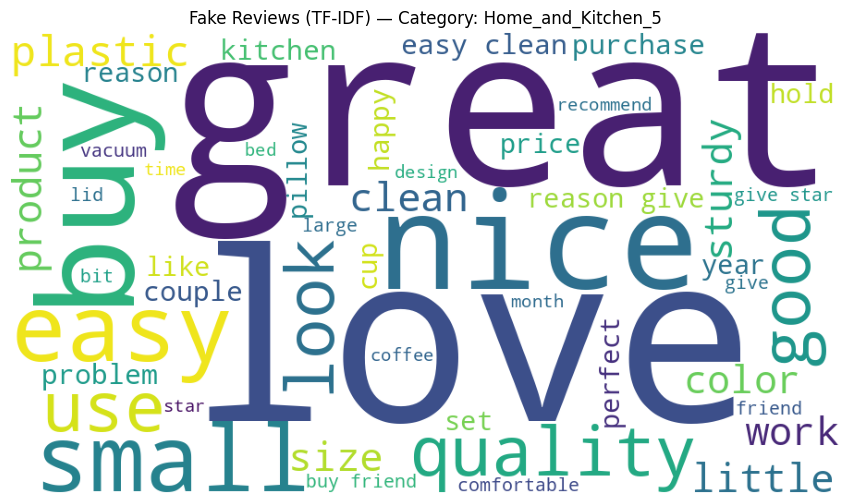

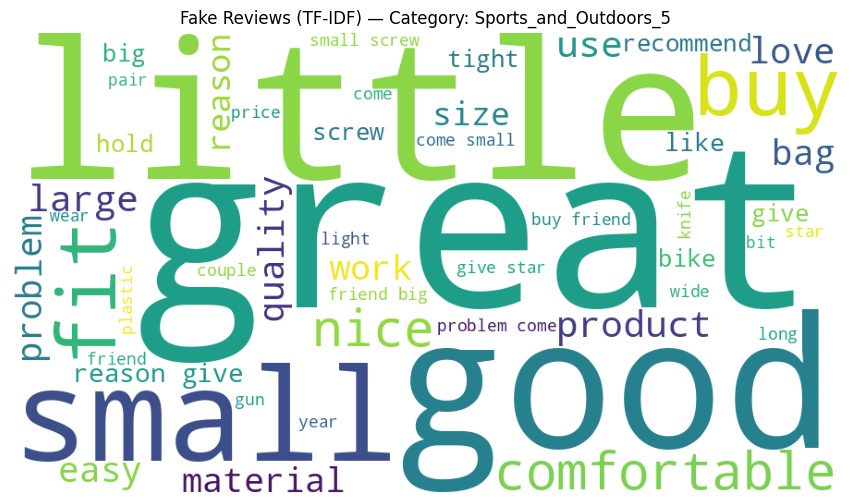

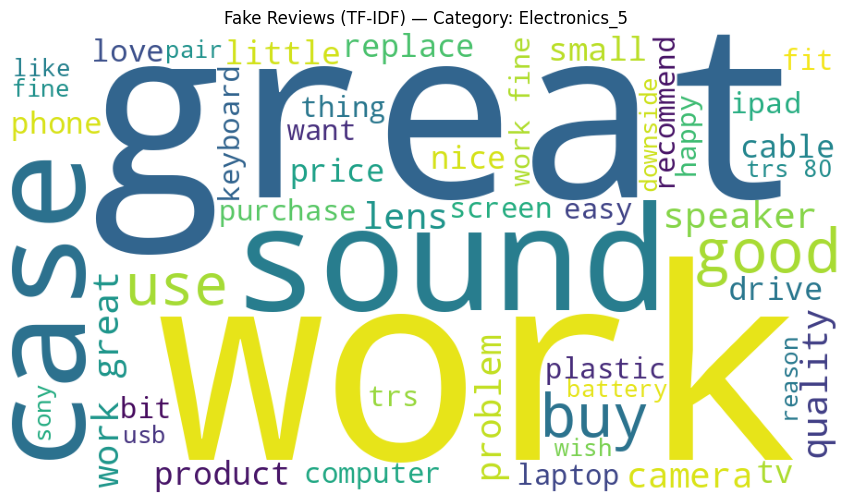

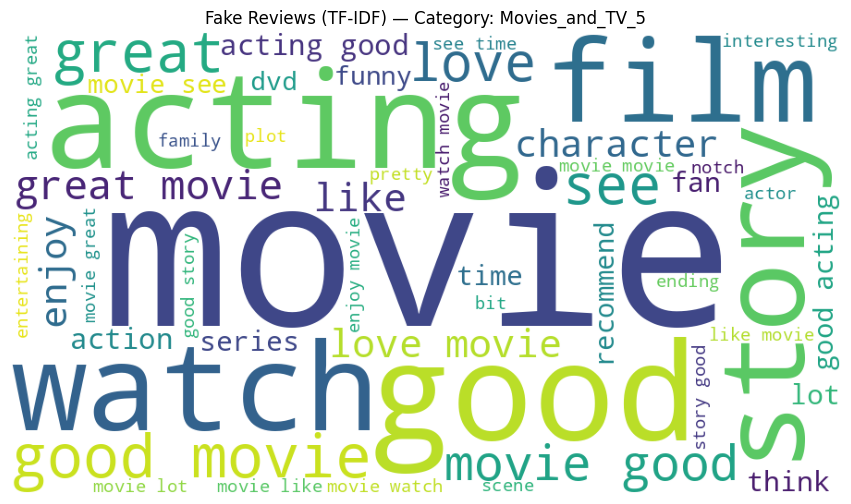

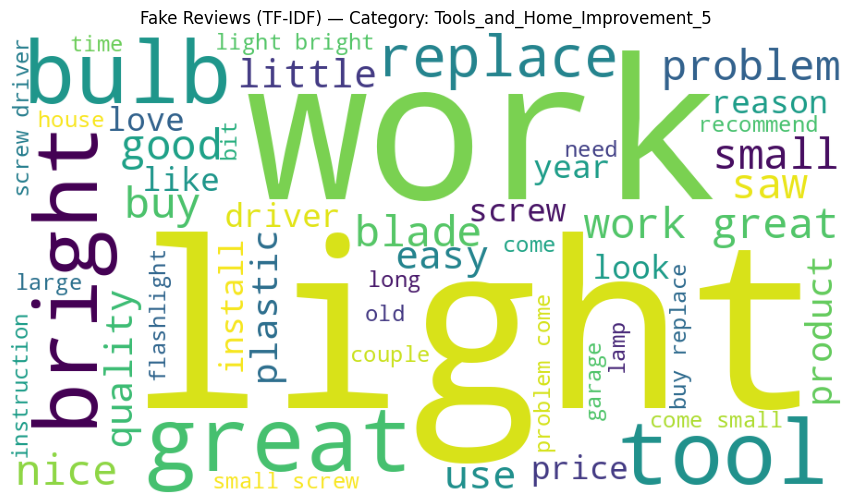

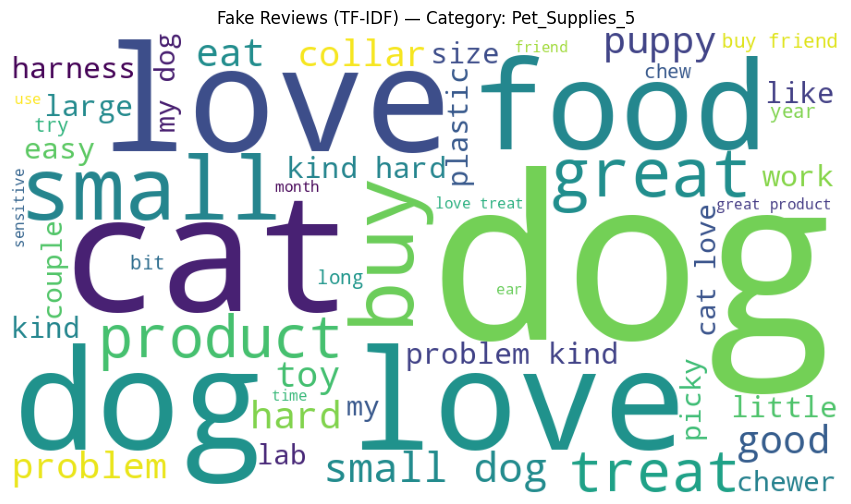

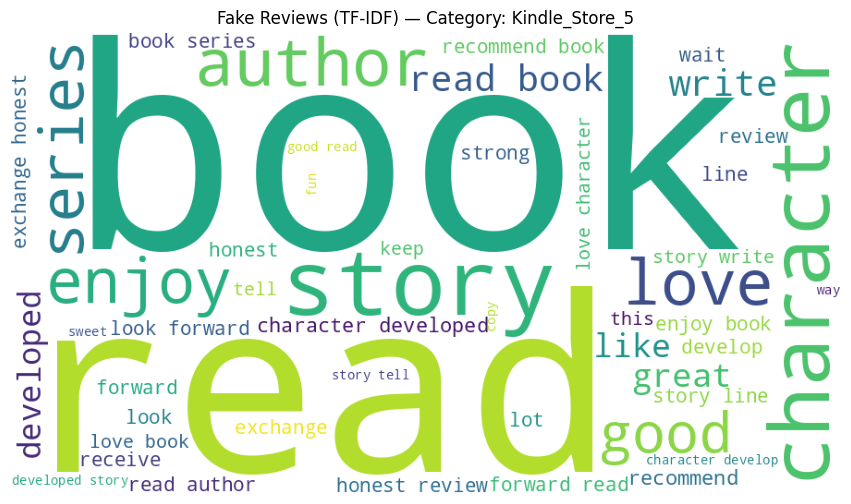

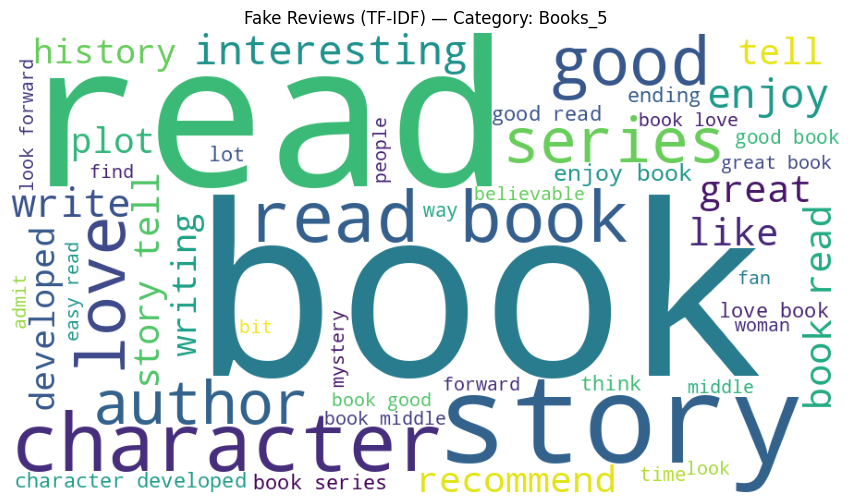

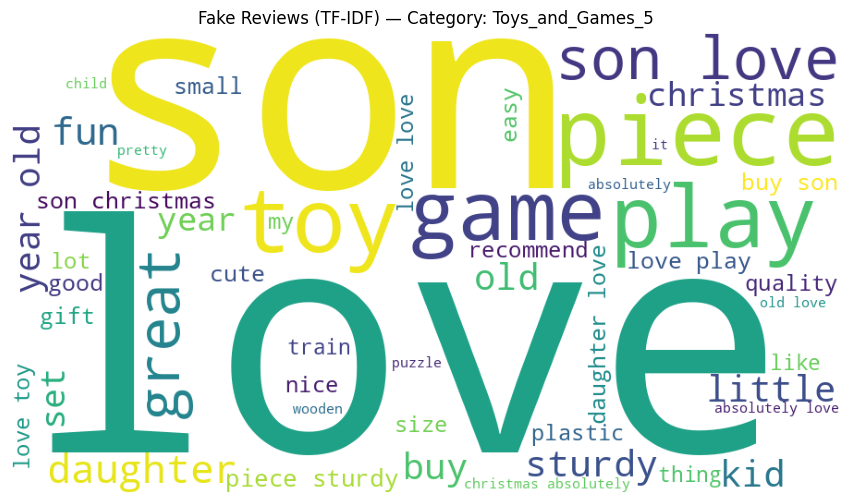

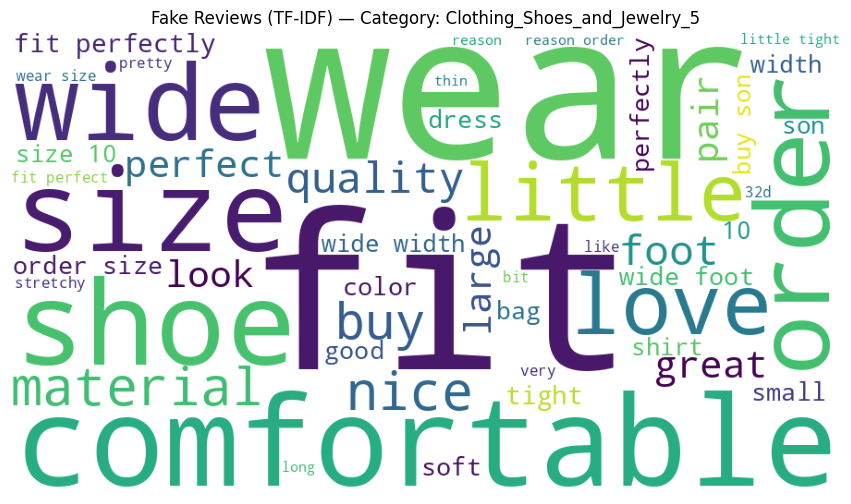

In [77]:
feature_names = np.array(vectorizer.get_feature_names_out())

categories = df["category"].unique()

for cat in categories:

    mask = (
        (df["category"] == cat) &
        (df["label"] == "CG")
    )

    if mask.sum() == 0:
        continue

    X_fake_cat = X[mask.values]

    mean_tfidf = np.asarray(X_fake_cat.mean(axis=0)).ravel()

    top_ids = mean_tfidf.argsort()[-50:]

    top_words = feature_names[top_ids]
    weights = mean_tfidf[top_ids]

    word_freq = dict(zip(top_words, weights))

    wc = WordCloud(
        width=900,
        height=500,
        background_color="white"
    )

    wc.generate_from_frequencies(word_freq)

    plt.figure(figsize=(12, 6))
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Fake Reviews (TF-IDF) — Category: {cat}")
    plt.show()
